# IMPORTS

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from textblob import TextBlob  
from collections import Counter


# SETTINGS

In [211]:
SETTINGS = {
    "DATA_RUTE": r"data/",
    "ORIGINAL_DATA_RUTE": r"data/original_data/",
    "DATA_VERSION": 3,
    
    "MODEL_SETTINGS":{
        "LAYER_SIZE": 128,
        "GENRE_THRESHOLD": 0.5,
        "TEST_SET": 0,
        "TEST_PROPORTION": 0.2,
        "SEED": 42,
    },
}

# DATA LOADING

In [289]:
if SETTINGS["DATA_VERSION"] == 0:
    column_names = [
        "wikipedia_movie_ID", 
        "freebase_movie_ID", 
        "name", 
        "release_date", 
        "box_office_revenue", 
        "runtime", 
        "languages", 
        "countries", 
        "genres"
    ]
    MOVIES = pd.read_csv(f'{SETTINGS["ORIGINAL_DATA_RUTE"]}movie.metadata.tsv', sep='\t', header=None, encoding='utf-8', na_values=['NA', ''], names=column_names)
    
elif SETTINGS["DATA_VERSION"] == 1: 
    MOVIES = pd.read_csv(f'{SETTINGS["DATA_RUTE"]}TMDB_movie_dataset_v11.csv')
    MOVIES = MOVIES.drop(columns=["homepage", "poster_path", "backdrop_path"])
    
elif SETTINGS["DATA_VERSION"] == 2: 
    column_names = [
        "name", 
        "rating", 
        "genre", 
        "release_year", 
        "status", 
        "score", 
        "votes", 
        "director", 
        "writer", 
        "star",
        "country", 
        "budget", 
        "box_office_revenue", 
        "company",
        "runtime", 
    ]
    MOVIES = pd.read_csv(f'{SETTINGS["DATA_RUTE"]}movies.csv', names=column_names)
    MOVIES = MOVIES.drop(columns=["director", "writer", "star"])
    MOVIES = MOVIES.drop(MOVIES.index[0])
    
elif SETTINGS["DATA_VERSION"] == 3:
    column_names = [
        "wikipedia_movie_ID", 
        "freebase_movie_ID", 
        "name", 
        "release_date", 
        "revenue", 
        "runtime", 
        "languages", 
        "countries", 
        "genres"
    ]
    MOVIES_ORIGINAL = pd.read_csv(f'{SETTINGS["ORIGINAL_DATA_RUTE"]}movie.metadata.tsv', sep='\t', header=None, encoding='utf-8', na_values=['NA', ''], names=column_names)
    
    column_names = [
        'id_new', 
        'title', 
        'vote_average', 
        'vote_count', 
        'status_new', 
        'release_date_new',
        'revenue_new', 
        'runtime_new', 
        'adult', 
        'backdrop_path', 
        'budget', 
        'homepage',
        'imdb_id', 
        'original_language', 
        'original_title', 
        'overview',
        'popularity', 
        'poster_path', 
        'tagline', 
        'genres_new',
        'production_companies', 
        'production_countries', 
        'spoken_languages',
        'keywords'
    ]
    MOVIES_NEW = pd.read_csv(f'{SETTINGS["DATA_RUTE"]}TMDB_movie_dataset_v11.csv', sep=',', header=None, encoding='utf-8', na_values=['NA', ''], names=column_names)
    
    
        
    MOVIES_ORIGINAL['name'] = MOVIES_ORIGINAL['name'].str.strip().str.lower()
    MOVIES_NEW['title'] = MOVIES_NEW['title'].str.strip().str.lower()
    
    MOVIES_ORIGINAL["release_year"] = pd.to_datetime(MOVIES_ORIGINAL['release_date'], errors='coerce').dt.year
    MOVIES_ORIGINAL["release_year"] = MOVIES_ORIGINAL["release_year"].fillna(0).astype(int)
    
    MOVIES_NEW["release_year_new"] = pd.to_datetime(MOVIES_NEW['release_date_new'], errors='coerce').dt.year
    MOVIES_NEW["release_year_new"] = MOVIES_NEW["release_year_new"].fillna(0).astype(int)
    
    MOVIES = pd.merge(MOVIES_ORIGINAL, MOVIES_NEW, left_on=['name', "release_year"], right_on=['title', 'release_year_new'], how='inner')
    MOVIES = MOVIES.drop(columns=[
        "id_new", "title", "status_new","imdb_id",
        "original_language", "original_title","tagline", "genres_new", 'production_companies', 
        'production_countries', 'spoken_languages', 'keywords', "homepage", "poster_path", "backdrop_path"
    ])    
    
elif SETTINGS["DATA_VERSION"] == 4:
    column_names = [
        "wikipedia_movie_ID", 
        "freebase_movie_ID", 
        "name", 
        "release_date", 
        "revenue", 
        "runtime", 
        "languages", 
        "countries", 
        "genres"
    ]
    MOVIES_ORIGINAL = pd.read_csv(f'{SETTINGS["ORIGINAL_DATA_RUTE"]}movie.metadata.tsv', sep='\t', header=None, encoding='utf-8', na_values=['NA', ''], names=column_names)
    
    column_names = [
        "names", 
        "date_x", 
        "score", 
        "genre", 
        "overview", 
        "crew", 
        "orig_title", 
        "status", 
        "orig_lang", 
        "budget_x", 
        "revenue", 
        "country"
    ]

    MOVIES_NEW = pd.read_csv(f'{SETTINGS["DATA_RUTE"]}imdb_movies.csv', sep=',', header=None, encoding='utf-8', na_values=['NA', ''], names=column_names)
    
    
        
    MOVIES_ORIGINAL['name'] = MOVIES_ORIGINAL['name'].str.strip().str.lower()
    MOVIES_NEW['names'] = MOVIES_NEW['names'].str.strip().str.lower()
    
        
    MOVIES_ORIGINAL["release_year"] = pd.to_datetime(MOVIES_ORIGINAL['release_date'], errors='coerce').dt.year
    MOVIES_ORIGINAL["release_year"] = MOVIES_ORIGINAL["release_year"].fillna(0).astype(int)
    
    MOVIES_NEW["release_year_new"] = pd.to_datetime(MOVIES_NEW['date_x'], errors='coerce').dt.year
    MOVIES_NEW["release_year_new"] = MOVIES_NEW["release_year_new"].fillna(0).astype(int)
    
    MOVIES = pd.merge(MOVIES_ORIGINAL, MOVIES_NEW, left_on=['name'], right_on=['names'], how='left')
    # MOVIES = MOVIES.drop(columns=[
    #     "id_new", "title", "status_new", "revenue_new", "runtime_new", "imdb_id",
    #     "original_language", "original_title", "overview", "tagline", "genres_new", 'production_companies', 
    #     'production_countries', 'spoken_languages', 'keywords', "homepage", "poster_path", "backdrop_path"
    # ])  

MOVIES.head()

C:\Users\mique\AppData\Local\Temp\ipykernel_40580\3741595841.py:81: DtypeWarning: Columns (0,2,3,6,7,8,10,16) have mixed types. Specify dtype option on import or set low_memory=False.
  MOVIES_NEW = pd.read_csv(f'{SETTINGS["DATA_RUTE"]}TMDB_movie_dataset_v11.csv', sep=',', header=None, encoding='utf-8', na_values=['NA', ''], names=column_names)
C:\Users\mique\AppData\Local\Temp\ipykernel_40580\3741595841.py:91: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  MOVIES_NEW["release_year_new"] = pd.to_datetime(MOVIES_NEW['release_date_new'], errors='coerce').dt.year


,wikipedia_movie_ID,freebase_movie_ID,name,release_date,revenue,runtime,languages,countries,genres,release_year,vote_average,vote_count,release_date_new,revenue_new,runtime_new,adult,budget,overview,popularity,release_year_new
0,975900,/m/03vyhn,ghosts of mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,5.127,977,2001-08-24,14010832,98,False,28000000,"In 2176, a Martian police unit is sent to pick...",14.189,2001
1,3196793,/m/08yl5d,getting away with murder: the jonbenét ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000,0.0,0,2000-02-16,0,60,False,0,Dramatization of the story behind the murder o...,0.6,2000
2,13696889,/m/03cfc81,the gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913,6.0,1,1913-05-29,0,35,False,0,An amusing burlesque of gang fighters. The pol...,0.6,1913
3,10408933,/m/02qc0j7,alexander's ragtime band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938,6.6,23,1938-05-24,4000000,106,False,2000000,"Classical violinist, Roger Grant disappoints h...",2.522,1938
4,2345652,/m/075f66,city of the dead,1960,NaN,76.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/03npn"": ""Horror"", ""/m/0fdjb"": ""Supernatur...",0,0.0,0,NaN,0,77,False,0,This is vintage horror stuff. A sleepy northea...,0.6,0


In [274]:
column_names = [
    "Wikipedia movie ID",
    "Freebase movie ID",
    "Movie release date",
    "Character name",
    "Actor date of birth",
    "Actor gender",
    "Actor height (in meters)",
    "Actor ethnicity (Freebase ID)",
    "Actor name",
    "Actor age at movie release",
    "Freebase character/actor map ID",
    "Freebase character ID",
    "Freebase actor ID"
]
CHARACTER = pd.read_csv(f'{SETTINGS["ORIGINAL_DATA_RUTE"]}character.metadata.tsv', sep='\t', header=None, encoding='utf-8', na_values=['NA', ''], names=column_names)

CHARACTER.head()

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [283]:
column_names = [
    "wikipedia_movie_ID",
    "plot"
]

PLOTS = pd.read_csv(f'{SETTINGS["ORIGINAL_DATA_RUTE"]}plot_summaries.txt', sep='\t', header=None, encoding='utf-8', names=column_names)
MOVIES = pd.merge(MOVIES, PLOTS, on="wikipedia_movie_ID", how="left")

MOVIES.head()

,wikipedia_movie_ID,freebase_movie_ID,name,release_date,revenue,runtime,languages,countries,genres,release_year,...,vote_count,release_date_new,revenue_new,runtime_new,adult,budget,overview,popularity,release_year_new,plot
0,975900,/m/03vyhn,ghosts of mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,...,977,2001-08-24,14010832,98,False,28000000,"In 2176, a Martian police unit is sent to pick...",14.189,2001,"Set in the second half of the 22nd century, th..."
1,3196793,/m/08yl5d,getting away with murder: the jonbenét ramsey ...,2000-02-16,0,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000,...,0,2000-02-16,0,60,False,0,Dramatization of the story behind the murder o...,0.6,2000,NaN
2,13696889,/m/03cfc81,the gangsters,1913-05-29,0,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913,...,1,1913-05-29,0,35,False,0,An amusing burlesque of gang fighters. The pol...,0.6,1913,NaN
3,10408933,/m/02qc0j7,alexander's ragtime band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938,...,23,1938-05-24,4000000,106,False,2000000,"Classical violinist, Roger Grant disappoints h...",2.522,1938,NaN
4,2345652,/m/075f66,city of the dead,1960,0,76.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/03npn"": ""Horror"", ""/m/0fdjb"": ""Supernatur...",0,...,0,NaN,0,77,False,0,This is vintage horror stuff. A sleepy northea...,0.6,0,NaN


In [276]:
MOVIES.columns

Index(['wikipedia_movie_ID', 'freebase_movie_ID', 'name', 'release_date',
       'revenue', 'runtime', 'languages', 'countries', 'genres',
       'release_year', 'vote_average', 'vote_count', 'release_date_new',
       'revenue_new', 'runtime_new', 'adult', 'budget', 'popularity',
       'release_year_new', 'plot'],
      dtype='object')

In [ ]:
MOVIES['runtime'] = MOVIES['runtime'].combine_first(MOVIES['runtime_new'])
MOVIES['revenue'] = MOVIES['revenue'].combine_first(MOVIES['revenue_new'])
MOVIES['plot'] = MOVIES['plot'].combine_first(MOVIES['overview'])

wikipedia_movie_ID       0
freebase_movie_ID        0
name                     0
release_date          1503
revenue                  0
runtime                  0
languages                0
countries                0
genres                   0
release_year             0
vote_average             0
vote_count               0
release_date_new      9951
revenue_new              0
runtime_new              0
adult                    0
budget                   0
overview              2508
popularity               0
release_year_new         0
plot                  1344
dtype: int64

In [290]:
len(MOVIES["wikipedia_movie_ID"]) - len(MOVIES["wikipedia_movie_ID"].unique())

6023

In [307]:
MOVIES[MOVIES.duplicated(subset=['wikipedia_movie_ID'], keep=False)].sort_values(by="wikipedia_movie_ID", ascending=False).head(50)

,wikipedia_movie_ID,freebase_movie_ID,name,release_date,revenue,runtime,languages,countries,genres,release_year,vote_average,vote_count,release_date_new,revenue_new,runtime_new,adult,budget,overview,popularity,release_year_new
3039,37283373,/m/0h63hnd,island,NaN,NaN,NaN,"{""/m/02h40lc"": ""English Language""}",{},"{""/m/01drsx"": ""Disaster""}",0,0.0,0,NaN,0,4,False,0,"An immigrant in Italy, away from his family wh...",0.6,0
3040,37283373,/m/0h63hnd,island,NaN,NaN,NaN,"{""/m/02h40lc"": ""English Language""}",{},"{""/m/01drsx"": ""Disaster""}",0,0.0,0,NaN,0,0,False,0,A maritime warden investigates an unauthorised...,0.6,0
3035,37283373,/m/0h63hnd,island,NaN,NaN,NaN,"{""/m/02h40lc"": ""English Language""}",{},"{""/m/01drsx"": ""Disaster""}",0,0.0,0,NaN,0,0,False,0,A man lost at sea washes up on an island.,0.6,0
3036,37283373,/m/0h63hnd,island,NaN,NaN,NaN,"{""/m/02h40lc"": ""English Language""}",{},"{""/m/01drsx"": ""Disaster""}",0,0.0,0,NaN,0,13,False,0,a short film by,0.6,0
3037,37283373,/m/0h63hnd,island,NaN,NaN,NaN,"{""/m/02h40lc"": ""English Language""}",{},"{""/m/01drsx"": ""Disaster""}",0,0.0,0,NaN,0,4,False,0,"A music video by Eli Hayes for Geomi’s track, ...",0.0,0
3038,37283373,/m/0h63hnd,island,NaN,NaN,NaN,"{""/m/02h40lc"": ""English Language""}",{},"{""/m/01drsx"": ""Disaster""}",0,0.0,0,NaN,0,0,False,0,"A haunting, deeply moving documentary set amon...",0.6,0
31109,37277581,/m/07k7km1,mental,NaN,NaN,74.0,"{""/m/02h40lc"": ""English Language""}",{},"{""/m/07s9rl0"": ""Drama""}",0,0.0,0,NaN,0,0,False,0,to be added later,0.6,0
31110,37277581,/m/07k7km1,mental,NaN,NaN,74.0,"{""/m/02h40lc"": ""English Language""}",{},"{""/m/07s9rl0"": ""Drama""}",0,0.0,0,NaN,50,140,True,100,mental mental mental,0.6,0
22302,36565748,/m/0hxql8w,passion,2013-02-21,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/0f8l9c"": ""France"", ""/m/06mkj"": ""Spain"", ""...","{""/m/01jfsb"": ""Thriller""}",2013,0.0,0,2013-05-17,0,118,True,0,Feel the Passion burn between five compelling ...,0.6,2013
22301,36565748,/m/0hxql8w,passion,2013-02-21,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/0f8l9c"": ""France"", ""/m/06mkj"": ""Spain"", ""...","{""/m/01jfsb"": ""Thriller""}",2013,5.6,6,2013-12-07,0,95,False,0,"A singular deadpan comedy, The Passion tells a...",1.792,2013


# DATA WRANGLING

- NANs
- Non sense values
- Gather sub-genre into general genre
- 
  ...

### Release date to year

In [ ]:
FIRST_MOVIE_YEAR = 1888
ACTUAL_YEAR = 2024

# if "release_date" in MOVIES.columns:
#     MOVIES["release_year"] = pd.to_datetime(MOVIES['release_date'], errors='coerce').dt.year
    
MOVIES["release_year"] = MOVIES["release_year"].fillna(0).astype(int)
MOVIES = MOVIES[(MOVIES["release_year"] >= FIRST_MOVIE_YEAR) & (MOVIES["release_year"] <= ACTUAL_YEAR) & (MOVIES["release_year"] != 0)]

print(f'Fist year: {MOVIES["release_year"].min()}, Last year: {MOVIES["release_year"].max()}')
MOVIES["release_year"]

Fist year: 1894, Last year: 2016


0        2001
1        2000
2        1913
3        1938
5        1997
         ... 
39962    2010
39963    1941
39964    2011
39965    2011
39966    1972
Name: release_year, Length: 30016, dtype: int32

### Runtime

In [ ]:
MOVIES["runtime"] = MOVIES["runtime"].fillna(0).astype(float)
#MOVIES = MOVIES[(MOVIES["runtime"] >= 40) & (MOVIES["runtime"] <= 200)]

MOVIES["runtime"]

0         98
1         95
2         35
3        106
4         76
        ... 
39962    103
39963     82
39964    120
39965     96
39966     66
Name: runtime, Length: 39967, dtype: int32

### Gather sub-genre into general genre

In [237]:
NEW_GENRE = pd.read_csv(f"categories.csv")
NEW_GENRE["subgenres"] = NEW_GENRE["subgenres"].apply(lambda x: ast.literal_eval(x))

NEW_GENRE.head()

,categories,subgenres
0,Action/Adventure,"[Action, Adventure, Action/Adventure, Martial ..."
1,Adaptation,"[Film adaptation, Remake, Live action, Reboot]"
2,Adult,"[Sex comedy, Erotica, Erotic thriller, Pornogr..."
3,Animation,"[Animation, Anime, Computer Animation, Clay an..."
4,Asian Movies,"[Bollywood, Filipino Movies, Chinese Movies, J..."


In [238]:
def get_hot_genre(genre):
    new_genre = []
    genre_hot = []
    
    movie_genre = set(genre)
    
    for _, row in NEW_GENRE.iterrows():
        sub_genres = set(row["subgenres"])
        if bool(movie_genre & sub_genres):
            new_genre.append(row["categories"])
            genre_hot.append(1)
        else: genre_hot.append(0)
    
    return new_genre, genre_hot


In [239]:
MOVIES["original_genres"] = MOVIES["genres"].apply(lambda x: ast.literal_eval(x).values())
MOVIES[["new_genres", "genre_hot"]] = MOVIES["original_genres"].apply(lambda x: pd.Series(get_hot_genre(x)))

In [240]:
MOVIES.head()

,wikipedia_movie_ID,freebase_movie_ID,name,release_date,revenue,runtime,languages,countries,genres,release_year,...,revenue_new,runtime_new,adult,budget,popularity,release_year_new,plot,original_genres,new_genres,genre_hot
0,975900,/m/03vyhn,ghosts of mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,...,14010832,98,False,28000000,14.189,2001,"Set in the second half of the 22nd century, th...","(Thriller, Science Fiction, Horror, Adventure,...","[Action/Adventure, Horror, Science Fiction, Su...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,3196793,/m/08yl5d,getting away with murder: the jonbenét ramsey ...,2000-02-16,0,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000,...,0,60,False,0,0.6,2000,NaN,"(Mystery, Biographical film, Drama, Crime Drama)","[Crime, Drama, Mystery/Suspense, Non-fiction/E...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ..."
2,13696889,/m/03cfc81,the gangsters,1913-05-29,0,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913,...,0,35,False,0,0.6,1913,NaN,"(Short Film, Silent film, Indie, Black-and-whi...","[Comedy, Indie, Old-fashioned/classical style,...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,10408933,/m/02qc0j7,alexander's ragtime band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938,...,4000000,106,False,2000000,2.522,1938,NaN,"(Musical, Comedy, Black-and-white)","[Comedy, Music/Dance, Old-fashioned/classical ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,2345652,/m/075f66,city of the dead,1960,0,76.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/03npn"": ""Horror"", ""/m/0fdjb"": ""Supernatur...",0,...,0,77,False,0,0.6,0,NaN,"(Horror, Supernatural)","[Horror, Supernatural/Monster]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [241]:
print(len(MOVIES_ORIGINAL["name"].unique()))
print(len(MOVIES_NEW["title"].unique()))
print(len(MOVIES["name"].unique()))
print(len(MOVIES))

75378
958661
30441
39967


# DATA EXPANSION
### Get the "theme" features for each movie

In [18]:
from theme_encoding import theme_encoding

# This is for demonstration purposes, but later on list of words will be in dataframes and not as individual lists like this
death_synonyms = [ "killed", "murdered", "assassinated", "slain", "shot", "stabbed", "executed", "died", "perished", "succumbed", "bled", "decapitated", "strangled", "blown", "electrocuted", "drowned", "burned", "poisoned", "crushed", "impaled", "asphyxiated", "bludgeoned", "suffocated", "choked", "eviscerated", "slaughtered", "disintegrated", "torn", "gutted", "hanged", "gassed", "slashed", "ripped", "cut", "disemboweled", "blasted", "tortured", "beheaded", "smashed", "mauled", "knifed", "eaten", "struck", "dismembered", "skinned", "hacked", "pummeled", "pierced", "overpowered", "collapsed", "punched", "squashed", "sliced", "flayed", "stomped", "shattered", "flattened", "scalded", "severed", "hit", "pinned", "decayed", "blasted", "bludgeoned", "throttled", "attacked", "electrocuted", "incinerated" ]

MOVIES["death_theme"] = theme_encoding(MOVIES["plot"], death_synonyms)

### Sentiment analysis of the plot

In [242]:
MOVIES['sentiment'] = MOVIES['plot'].apply(lambda x: TextBlob(str(x)).sentiment.polarity if pd.notnull(x) else None)

MOVIES['sentiment'].head()

0   -0.085095
1         NaN
2         NaN
3         NaN
4         NaN
Name: sentiment, dtype: float64

# Data analysis

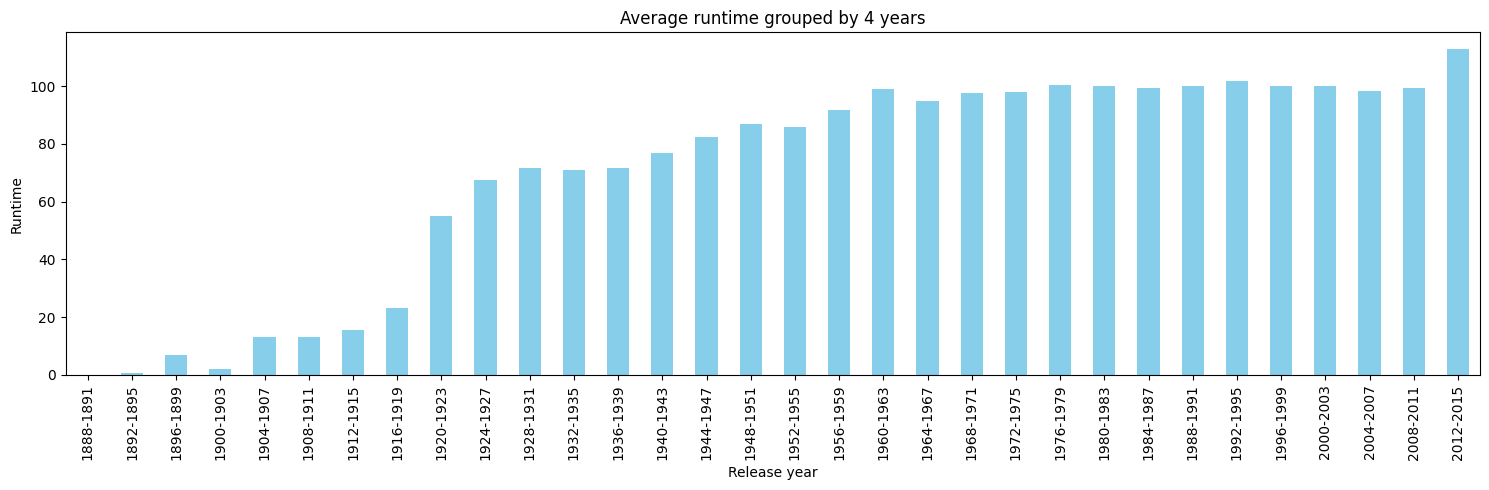

In [249]:
movies_year_runtime = MOVIES.groupby("release_year")["runtime"].median()

bin_size = 4
binned_runtimes = {}

for i in range(FIRST_MOVIE_YEAR, int(movies_year_runtime.index.max()), bin_size):
    bin_start, bin_end = i, i + bin_size - 1
    
    # Calculate the mean runtime within the current year range (bin)
    total_in_bin = movies_year_runtime[
        (movies_year_runtime.index >= bin_start) & 
        (movies_year_runtime.index <= bin_end)
    ].median()
    
    # Store result in dictionary with bin label as key
    binned_runtimes[f'{bin_start}-{bin_end}'] = total_in_bin

binned_token_counts = pd.Series(binned_runtimes)

# Plot
plt.figure(figsize=(15, 5))
binned_token_counts.plot(kind='bar', color='skyblue')

plt.xlabel('Release year')
plt.ylabel('Runtime')
plt.title(f'Average runtime grouped by {bin_size} years')

plt.tight_layout()
plt.show()

### Genre runtime analysis

In [254]:
MOVIES["new_genres"]

0        [Action/Adventure, Horror, Science Fiction, Su...
1        [Crime, Drama, Mystery/Suspense, Non-fiction/E...
2        [Comedy, Indie, Old-fashioned/classical style,...
3        [Comedy, Music/Dance, Old-fashioned/classical ...
4                           [Horror, Supernatural/Monster]
                               ...                        
39962                                      [Comedy, Drama]
39963      [Comedy, Crime, Supernatural/Monster, Thriller]
39964                                              [Drama]
39965                     [Drama, Non-fiction/Educational]
39966                                             [Comedy]
Name: new_genres, Length: 39967, dtype: object

Action/Adventure
Adaptation
Adult
Animation
Asian Movies
Children's/Family
Comedy
Coming of age
Crime
Culture & Society
Disaster/Dystopia
Drama
Fantasy
Friendships, Family & Personal Relationships
Historical
Holiday Film
Horror
Indie
LGBT
Music/Dance
Mystery/Suspense
Non-fiction/Educational
Old-fashioned/classical style
Political
Prison
Religious Film
Romance
Science Fiction
Short Film
Sports
Spy
Supernatural/Monster
Teen
Thriller
Unconventional
War/combat
Western
World cinema
Other


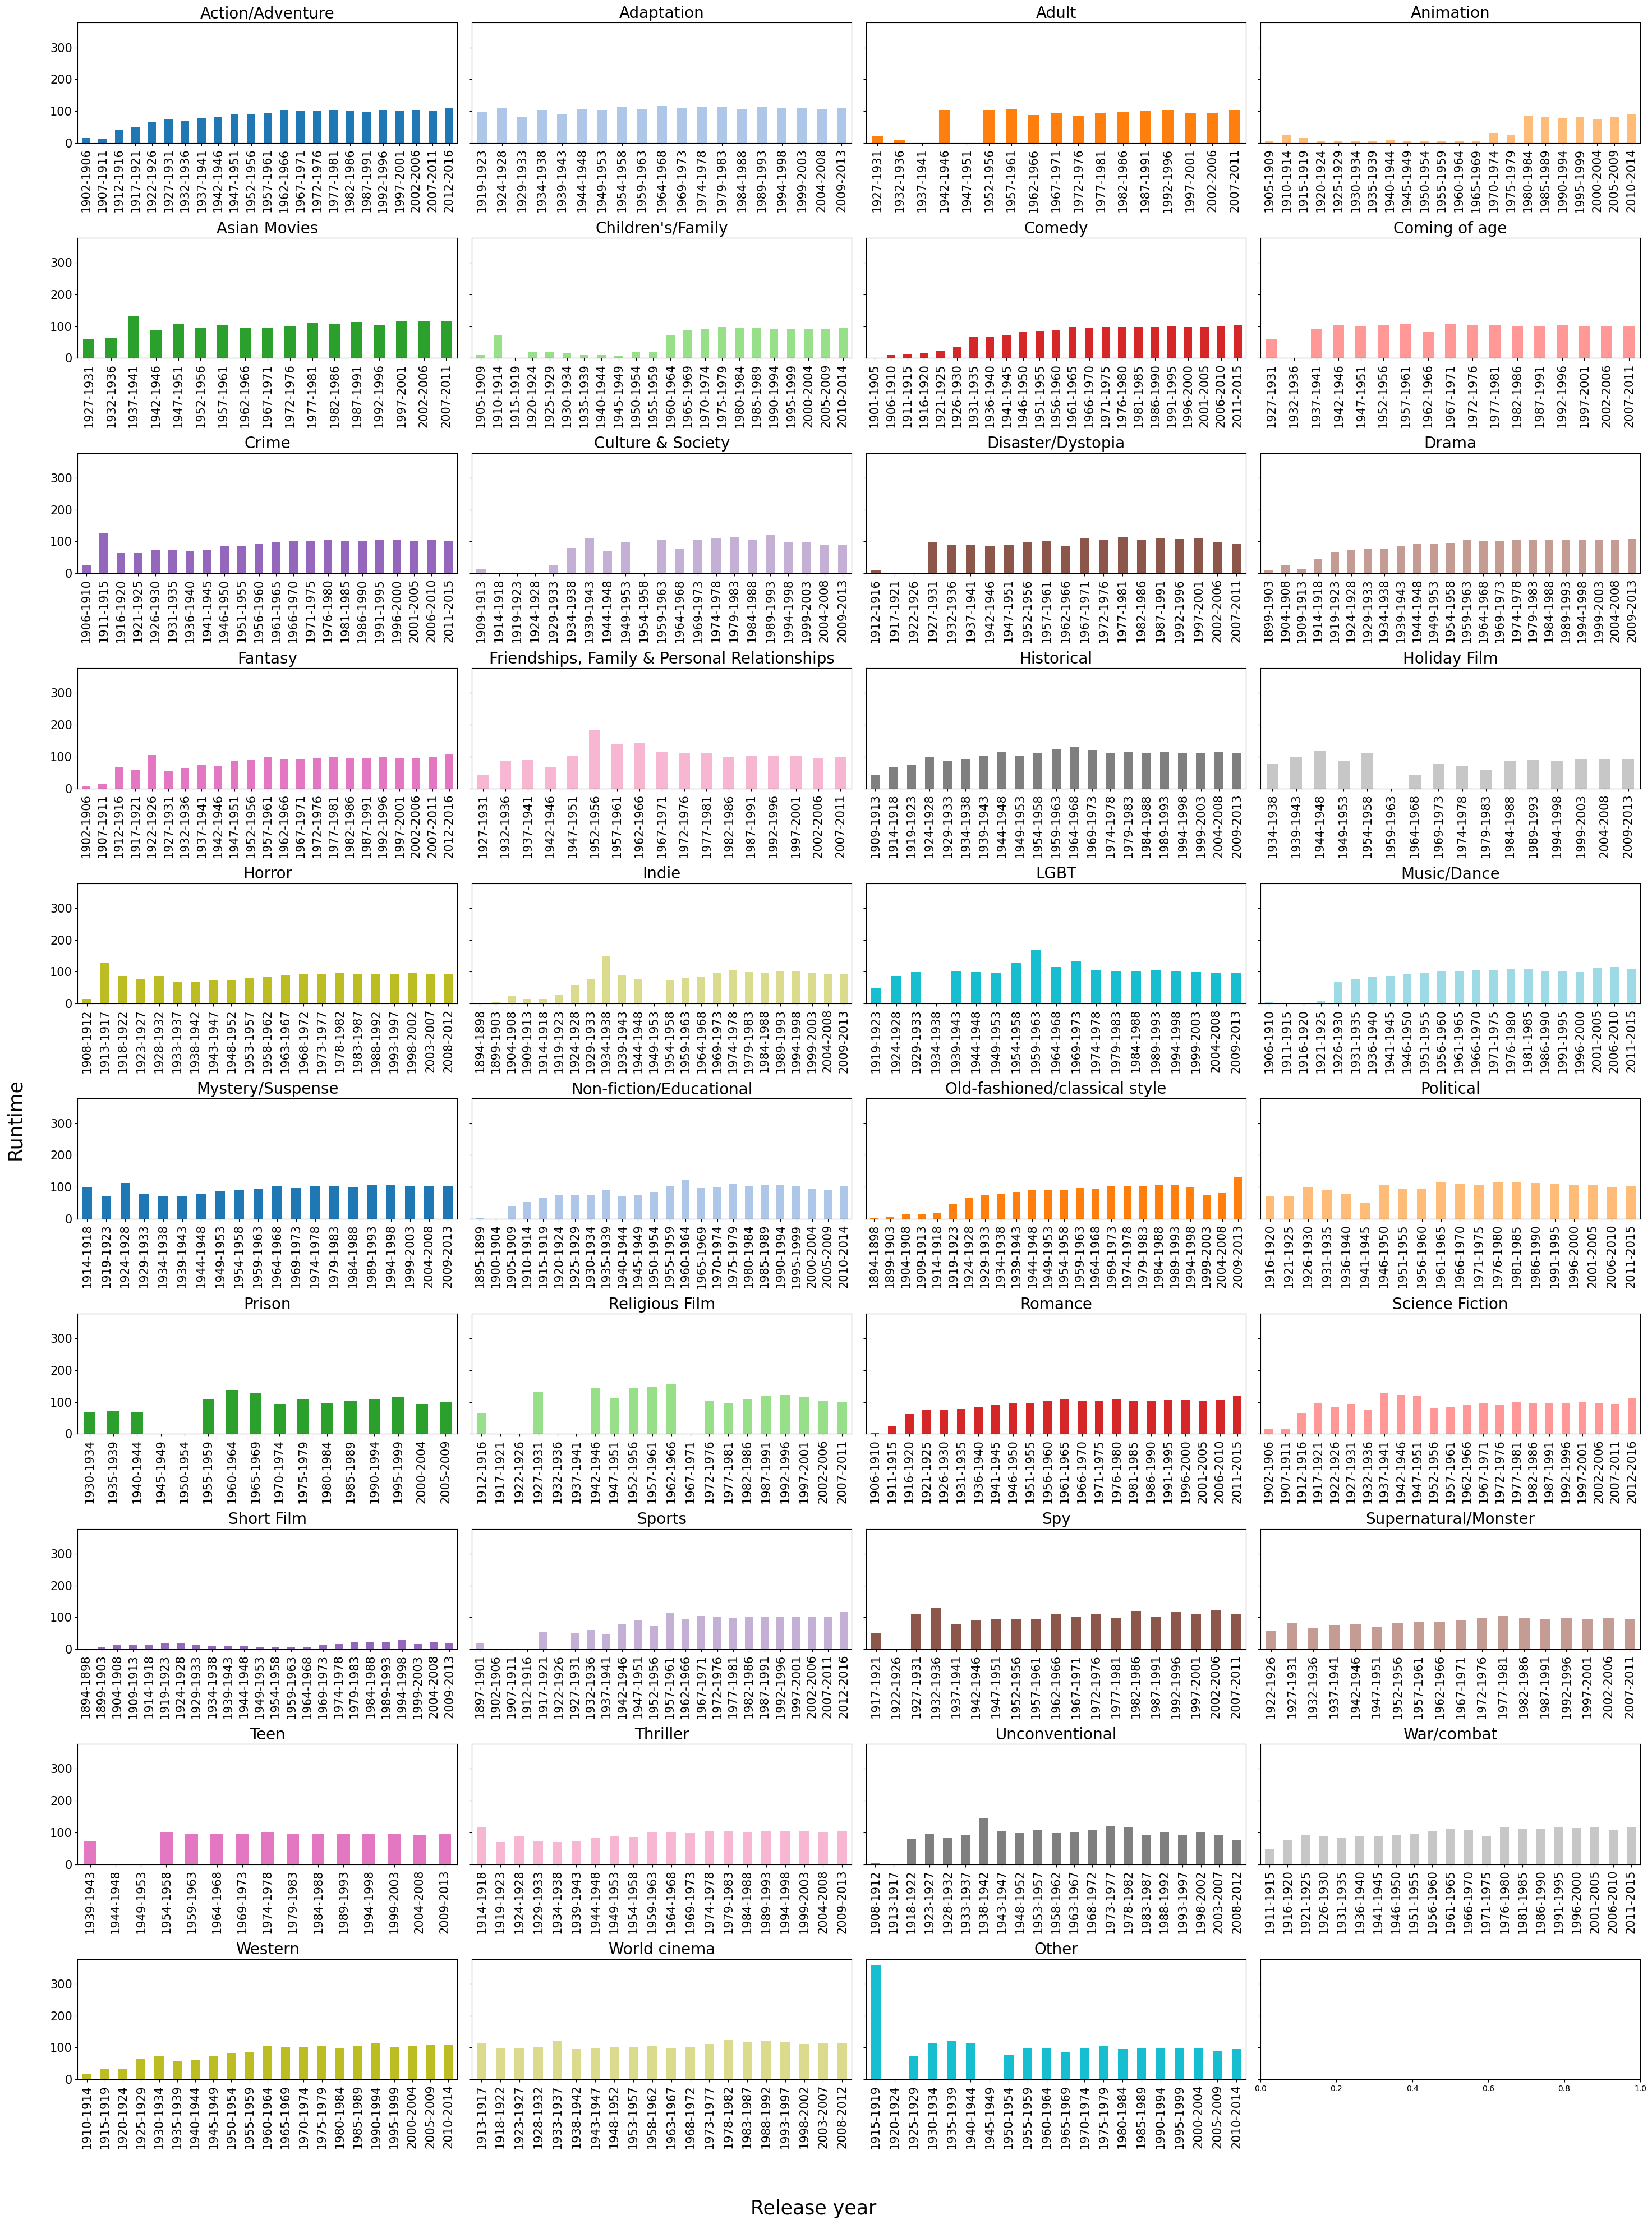

In [272]:
unique_genre = NEW_GENRE["categories"]

# MOVIES["new_genres"].apply(lambda x: unique_genre.extend(x))
# print(len(unique_genre))
# unique_genre = {k: v for k, v in sorted(unique_genre.items(), key=lambda item: item[1], reverse=True)}
# unique_genre = {k: unique_genre[k] for k in list(unique_genre)[:20]}
#unique_genre = {x:unique_genre[x] for x in unique_genre if unique_genre[x] >= 300}


fig, axes = plt.subplots(10, 4, figsize=(30, 40), sharey = True)
#fig.delaxes(axes[4, 3])
colors = sns.color_palette("tab20", len(unique_genre))
color_iter = iter(colors)

for j, genre in enumerate(unique_genre):
    print(genre)
    df_filtered = MOVIES[MOVIES["new_genres"].apply(lambda x: genre in x)]
    if len(df_filtered) == 0: continue
    bin_size = 5
    movies_year_runtime = df_filtered.groupby("release_year")["runtime"].median()
    binned_counts = {}
    for i in range(int(movies_year_runtime.index.min()), int(movies_year_runtime.index.max()), bin_size):
        bin_start, bin_end = i, i + bin_size - 1
        
        # Sum all the runtimes counts in this range.
        total_in_bin = movies_year_runtime[(movies_year_runtime.index >= bin_start) & (movies_year_runtime.index <= bin_end)].mean()
        
        binned_counts[f'{bin_start}-{bin_end}'] = total_in_bin


    binned_token_counts = pd.Series(binned_counts)
    color = next(color_iter)
    ax = axes[j//4, j%4]
    binned_token_counts.plot(kind='bar', ax=ax, color=color, fontsize=15)

    ax.set_title(genre, size = 20)
fig.supxlabel('Release year', size = 25)
fig.supylabel('Runtime', size = 25)
fig.tight_layout(rect=(0.025,0.025,1,1))

Text(0.5, 1.0, 'Genre vs runtime')

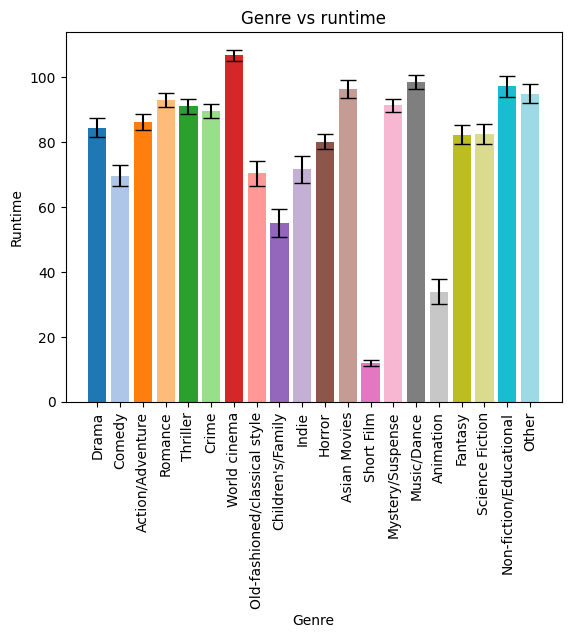

In [50]:
fig, ax = plt.subplots()
colors = sns.color_palette("tab20", len(unique_genre))
color_iter = iter(colors)
average = []
std = []
number_of_year_to_average = 5

for idx, genre in enumerate(unique_genre):

    df_filtered = MOVIES[MOVIES["new_genres"].apply(lambda x: genre in x)]
    medians = df_filtered.groupby("release_year")["runtime"].median()
    average.append(medians.mean())
    std.append(medians.std()/np.sqrt(medians.size))
    
ax.tick_params(axis='x', labelrotation=90)
for i in range(len(unique_genre)):
    color = next(color_iter)
    ax.bar(list(unique_genre.keys())[i], average[i], color=color)
    ax.errorbar(list(unique_genre.keys())[i], average[i], yerr=std[i],capsize=6,  color = 'k')
ax.set_xlabel("Genre")
ax.set_ylabel("Runtime")
ax.set_title("Genre vs runtime")

### Genre revenue analysis

Text(0.5, 1.0, 'Genre vs runtime')

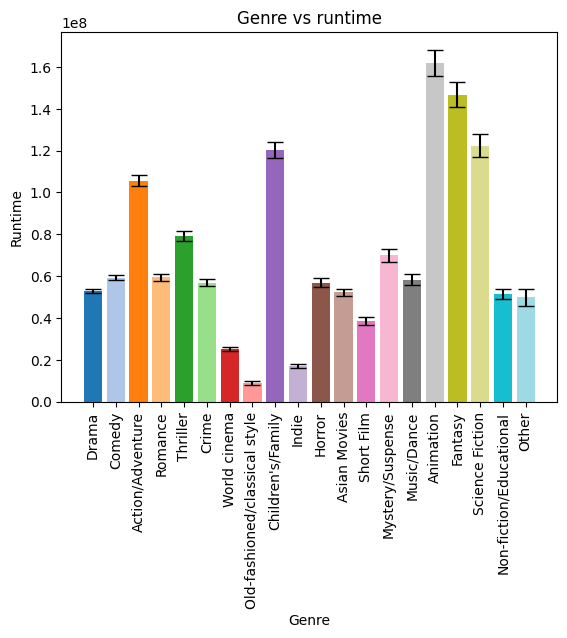

In [ ]:
fig, ax = plt.subplots()
colors = sns.color_palette("tab20", len(unique_genre))
color_iter = iter(colors)
average = []
std = []
number_of_year_to_average = 5

for idx, genre in enumerate(unique_genre):

    df_filtered = MOVIES[MOVIES["new_genres"].apply(lambda x: genre in x)]
    df_filtered['revenue'].fillna(df_filtered['revenue'].median())
    group = df_filtered['revenue']
    average.append(group.mean())
    std.append(group.std()/np.sqrt(group.size))
    
ax.tick_params(axis='x', labelrotation=90)
for i in range(len(unique_genre)):
    color = next(color_iter)
    ax.bar(list(unique_genre.keys())[i], average[i], color=color)
    ax.errorbar(list(unique_genre.keys())[i], average[i], yerr=std[i],capsize=6,  color = 'k')

ax.set_xlabel("Genre")
ax.set_ylabel("Runtime")
ax.set_title("Genre vs revenue")

# Character managment

In [ ]:
vgh

# MOVIE GENRE PREDICTOR MODEL

In [15]:
import random
import torch

### Data spliting and cross validation definition

In [ ]:
def cross_validation_balanced_split(data, training_columns, testing_column, set_to_test, train_proportion = 0.2, seed = 42):
    divisions = int(1 / train_proportion)
    if set_to_test is None or set_to_test > divisions or set_to_test < 0:
        print("BE CAREFUL, ONLY VALUES FORM 0 to 1. Setting testing set to 0")
        set_to_test = 0
    # GET THE MOST FROM THE UNBALANCED CLASS
    train_proportion = train_proportion # 1/train_proportion divisioins, as default 2
    n = np.round(train_proportion, 0).astype(int)
        
    data_suffled = data.sample(frac=1, random_state=seed).reset_index(drop=True)

    training_set =  data_suffled[:n*set_to_test] + data_suffled[n*(set_to_test+1):] 
    testing_set = data_suffled[n*set_to_test:n*(set_to_test+1)]

    return (
        training_set[training_columns], 
        training_set[testing_column], 
        testing_set[training_columns], 
        testing_set[testing_column], 
    )

In [ ]:
training_columns = []
testing_column = []

training_set, training_target_set, testing_set, testing_target_set = cross_validation_balanced_split(MOVIES, 
                                                                                                     training_columns,
                                                                                                     testing_column,
                                                                                                     set_to_test = SETTINGS["MODEL_SETTINGS"]["TEST_SET"], 
                                                                                                     train_proportion =  SETTINGS["MODEL_SETTINGS"]["TEST_PROPORTION"],
                                                                                                     seed = SETTINGS["MODEL_SETTINGS"]["SEED"],
                                                                                                     )

### Model definition

In [23]:
get_model = lambda feature_size, genre_size, layer_size: torch.nn.Sequential(
    # Input layer
    torch.nn.Linear(feature_size, layer_size),
    torch.nn.ReLU(),
    
    # Hidden layers
    torch.nn.Linear(layer_size, layer_size),
    torch.nn.ReLU(),
    torch.nn.Linear(layer_size, layer_size),
    torch.nn.ReLU(),
    torch.nn.Linear(layer_size, layer_size),
    torch.nn.ReLU(),
    
    # Output layer
    torch.nn.Linear(layer_size, genre_size),
    torch.nn.Sigmoid() # To get probabilities
)

### Model instance

In [24]:
feature_size = 30 #len(training_columns)
genre_size = 30 #len(movie_genre)

model_factory = lambda: get_model(feature_size, genre_size, SETTINGS["MODEL_SETTINGS"]["LAYER_SIZE"])
model = model_factory()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device=device)

optimizer_kwargs = dict(
    lr=3e-4,
    weight_decay=1e-3,
)
optimizer = torch.optim.AdamW(model.parameters(), **optimizer_kwargs)

### Model training

In [ ]:
def train_model(batches_train, batches_test, model, optimizer, classification_threshold, device):
    # Set model to training mode 
    model.train()

    loss_history = []
    accuracy_history = []
    f_score_history = []
    precision_history = []
    recall_history = []
    # Change the loop to get batch_idx, data and target from train_loader
    for sample_i, (data, target) in enumerate(zip(batches_train, batches_test)):
        N = data.shape[0] 
        Dy = target.shape[1] # Number of possible genre 
        
        # Move the data to the device
        data = data.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        
        loss = torch.nn.BCELoss()(output, target)
        loss_float = loss.item()
        # Backpropagate loss & Perform an optimizer step
        loss.backward()
        optimizer.step()
        
        
        # Compute accuracy and loss of the batch
        output_hot, correct = get_output_hot(output, target, classification_threshold)
        accuracy = correct.item() / (N * Dy) 
        f_score, precision, recall = compute_avg_f_score(output_hot, target)
        
        accuracy_history.append(accuracy)
        loss_history.append(loss_float)
        f_score_history.append(f_score)
        precision_history.append(precision)
        recall_history.append(recall)
        
        if sample_i % (1000 // N) == 0: # Every 1000 samples
            print(f'Batch {loss_float = :.3f}')
            print(f'Batch {accuracy = :.3f}')
            print(f'Batch {f_score = :.3f}')
            print(f'Batch {precision = :.3f}')
            print(f'Batch {recall = :.3f}')
    # print(f"{loss_history = }, {accuracy_history = }")
    return model, loss_history, accuracy_history

def get_output_hot(output, target, classification_threshold):
    output_hot = (output > classification_threshold).int() # we have |N| x |genre| matrix
    correct = torch.sum(output_hot == target)

    return output_hot, correct

def compute_avg_f_score(output_hot, target):
    true_positives = torch.sum((output_hot & target), dim = 1)
    false_positives = torch.sum((output_hot & ~target), dim = 1)
    false_negatives = torch.sum((~output_hot & target), dim = 1)
    
    denominator = true_positives + false_positives
    precision = torch.where(denominator > 0,
                            true_positives / denominator,
                            torch.zeros_like(true_positives)
                            )
    
    denominator = true_positives + false_negatives
    recall = torch.where(denominator > 0,
                         true_positives / denominator,
                         torch.zeros_like(true_positives)
                         )
    
    denominator = precision + recall
    f_score = torch.where(denominator > 0,
                          2*(precision * recall) / denominator,
                          torch.zeros_like(true_positives)
                          )
                          
    return torch.mean(f_score), torch.mean(precision), torch.mean(recall)

We use stochastic training for better performance. The batch size is 10 by default.

In [26]:
def get_training_batch(training_set, target_set, batch_size = 10):
    assert len(training_set) == len(target_set), "Lists must be of equal length."
    
    batches_train = []
    batches_test = []
    for i in range(0, len(training_set), batch_size):
        # batches_train.append(training_set[i:i+batch_size])
        # batches_test.append(target_set[i:i+batch_size])
        batches_train.append(torch.tensor(training_set[i:i+batch_size]))
        batches_test.append(torch.tensor(target_set[i:i+batch_size]))
        
    return batches_train, batches_test

In [ ]:
batches_train, batches_test = get_training_batch(training_set, training_target_set)

trained_model, train_loss, train_acc = train_model(
    batches_train, batches_test, model, optimizer, SETTINGS["MODEL_SETTINGS"]["GENRE_THRESHOLD"], device
) 

### Training Plotting

In [ ]:
batch_indices = [i for i in range(len(batches_train))]

plt.figure(figsize=(6.4, 4.8))
plt.subplot(1, 2, 1)
plt.plot(batch_indices, trained_model)
plt.xlabel("Batch")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(batch_indices, train_loss)
plt.xlabel("Batch")
plt.ylabel("Loss")

### Model testing

In [ ]:
def test_model(model, testing_set, testing_target_set, classification_threshold):
    N = testing_set.shape[0] 
    Dy = testing_target_set.shape[1] 
    
    with torch.no_grad():
        output = model(testing_set)
        
    output_hot, correct = get_output_hot(output, testing_target_set, classification_threshold)
    
    accuracy = correct.item() / (N * Dy) 
    
    print(f'Testing accuracy = {accuracy:0.3f}')
    
    return output_hot
    

In [ ]:
testing_set = torch.tensor(testing_set).to(device)
testing_target_set = torch.tensor(testing_target_set).to(device)

predictions = test_model(trained_model, testing_set, testing_target_set, SETTINGS["MODEL_SETTINGS"]["GENRE_THRESHOLD"])

genre_labels = ["Action", "Drama", "Comedy", "Sci-Fi", "Horror", "Romance", "Documentary", "Fantasy", "Thriller", "Animation"]
predicted_genre = []

for movie_prediction in predictions:
    genres = [genre_labels[i] for i, is_genre in enumerate(movie_prediction) if is_genre == 1]
    predicted_genre.append(genres)

predictins_output = pd.DataFrame({
    'wikipedia_movie_ID': testing_set["wikipedia_movie_ID"],
    'name': testing_set["name"],
    'predicted_genres': predicted_genre,
})


predictins_output.to_csv("movies_predicted_genre.csv", index = False)


# TRASH CODE TESTING

In [ ]:
training_set = [i for i in range(1, 105)]
training_target_set = [i**2 for i in range(1, 105)]


batches_train, batches_test = get_training_batch(training_set, training_target_set)

print(batches_train, batches_test)

for sample_i, (data, target) in enumerate(zip(batches_train, batches_test)):
     print(f"\n\n{sample_i = }")
     print(f"{data = }")
     print(f"{target = }")

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [11, 12, 13, 14, 15, 16, 17, 18, 19, 20], [21, 22, 23, 24, 25, 26, 27, 28, 29, 30], [31, 32, 33, 34, 35, 36, 37, 38, 39, 40], [41, 42, 43, 44, 45, 46, 47, 48, 49, 50], [51, 52, 53, 54, 55, 56, 57, 58, 59, 60], [61, 62, 63, 64, 65, 66, 67, 68, 69, 70], [71, 72, 73, 74, 75, 76, 77, 78, 79, 80], [81, 82, 83, 84, 85, 86, 87, 88, 89, 90], [91, 92, 93, 94, 95, 96, 97, 98, 99, 100], [101, 102, 103, 104]] [[1, 4, 9, 16, 25, 36, 49, 64, 81, 100], [121, 144, 169, 196, 225, 256, 289, 324, 361, 400], [441, 484, 529, 576, 625, 676, 729, 784, 841, 900], [961, 1024, 1089, 1156, 1225, 1296, 1369, 1444, 1521, 1600], [1681, 1764, 1849, 1936, 2025, 2116, 2209, 2304, 2401, 2500], [2601, 2704, 2809, 2916, 3025, 3136, 3249, 3364, 3481, 3600], [3721, 3844, 3969, 4096, 4225, 4356, 4489, 4624, 4761, 4900], [5041, 5184, 5329, 5476, 5625, 5776, 5929, 6084, 6241, 6400], [6561, 6724, 6889, 7056, 7225, 7396, 7569, 7744, 7921, 8100], [8281, 8464, 8649, 8836, 9025, 9216, 9409, 9604, 

In [34]:
hot =  torch.tensor([[0,0,0,0,0,0,0,0,0,1], [0,0,0,0,0,0,0,0,1,1], [0,0,0,0,0,1,0,0,0,1], [0,0,0,0,0,0,1,0,0,1], [0,0,0,0,0,1,0,0,0,1]])
targ = torch.tensor([[0,0,0,0,0,0,0,0,0,1], [0,0,0,0,0,0,0,0,0,1], [0,0,0,0,0,1,1,0,0,1], [0,0,0,0,0,1,0,0,0,1], [0,0,0,0,0,1,0,1,1,1]])

f_score, precision, recall = compute_avg_f_score(hot, targ)
print(f'{f_score = :.3f}, {precision = :.3f}, {recall = :.3f},')

f_score = 0.727, precision = 0.800, recall = 0.733,
